# Exploratory Data Analysis

This notebook contains the code for exploratory data analysis. It will focus on extracting data from the replays as a whole. The following steps will be followed:
1. Create a list of all replays with a relative link to their files.
    * Replays will be identified by their filehash, duplicate filehashes will not be added to the list.
    * First create the table as a pandas dataframe, after which it can be written to csv.
    * The list will be saved in the root of the `data/` folder, and this will be used as the reference point for relative file paths.
    * Only 1v1 replays will be considered. This will be confirmed from the `game_type` attribute.
2. Extract relevant data from replay files. The following data will be extracted:
    * Map
    * Player names
    * Player races
    * Player levels (if available)
    * Player highest league (if available)
    * Date
    * Length
    * Winner
3. Add all relevant data to the csv
4. Data exploration
    * Initial data visualization.
    * Cleaning any missing data.
5. Initial modeling of metadata to observe any interesting trends.

In [43]:
# initial imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sc2reader
import re
import random
import datetime
import json
from scripts.classes import ReplayInfo
import time
import math

# sklearn
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# import svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

# import random forest
from sklearn.ensemble import RandomForestClassifier

# import KNN
from sklearn.neighbors import KNeighborsClassifier

# import grid_search
from sklearn.model_selection import GridSearchCV

# import warnings
import warnings

In [44]:
#### Matplotlib settings
%matplotlib inline
import matplotlib as mpl

# specify default rcParams so that fontsize, weight and style do not need to set
# each time
# Title in bold, fontsize 20
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 20
# Plot fontsize 12 and bold
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['axes.labelsize'] = 13
# set figure size
mpl.rcParams['figure.figsize'] = (15, 8)

# race list and colors that will be used to represent them
RACE_LIST = [
    'Protoss',
    'Terran',
    'Zerg'
    ]
COLOR_DICT = {
    'Protoss': 'goldenrod',
    'Terran': 'firebrick',
    'Zerg': 'darkviolet'
    }

## Data Cleaning
Begin data cleaning by removing all replays:
* that are not 1v1.
* without a winner.
* with a length of less than 5 or more than 60 minutes.
* with invalid player races.
* with invalid player mmrs.
* where game_speed not Faster.
* where is_lader is not True.
* where fps is not 16.
* where region is not 'eu', 'us', 'cn', kr'

In [45]:
# load replay_df from csv
replay_df = pd.read_csv('data/replays.csv')
display(replay_df.head())
replay_df.info()

,filename,map,player1_race,player2_race,player1_mmr,player2_mmr,game_length,game_type,game_speed,game_winner,timestamp,fps,is_ladder,region,player1_highest_league,player2_highest_league,filehash
0,C:/Users/jared/Gits/sc2-modeling/data/Spawning...,abb20e9c587f5f6ce279a6aa8c7e9be2897607abb00434...,Terran,Protoss,-36400.0,NaN,402,1v1,Normal,1,1633598712,16.0,False,us,4,0,9384fda8c370ea7d130ac20244f7d0fda9a9b834004445...
1,C:/Users/jared/Gits/sc2-modeling/data/Spawning...,abb20e9c587f5f6ce279a6aa8c7e9be2897607abb00434...,Terran,Zerg,-36400.0,NaN,371,1v1,Normal,1,1633603684,16.0,False,us,4,0,f9864054498acf297aacf2be80896ba131716a341983de...
2,C:/Users/jared/Gits/sc2-modeling/data/Spawning...,c2bcc137d9ce43fbf9a5ddd04f5167892c779c29616de9...,Zerg,Zerg,4022.0,3502.0,371,1v1,Faster,1,1633788999,16.0,True,eu,6,6,178a82fa5045e82a3920688274d7a524595f0ef6dc91ae...
3,C:/Users/jared/Gits/sc2-modeling/data/Spawning...,e83bd9ddb33fcdc21a801f9bd598ed081f8ca60f810522...,Zerg,Protoss,NaN,NaN,1803,1v1,Faster,1,1630608640,16.0,False,eu,7,6,99ba80721116d18f965c141581baa878abf02526f48bc6...
4,C:/Users/jared/Gits/sc2-modeling/data/Spawning...,e83bd9ddb33fcdc21a801f9bd598ed081f8ca60f810522...,Zerg,Protoss,3615.0,3567.0,502,1v1,Faster,1,1633138764,16.0,True,us,5,5,b9e96a1dabcc0de0cfd89e8f0d02b5b8e064ec3f3c07c1...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36812 entries, 0 to 36811
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   filename                36812 non-null  object 
 1   map                     36812 non-null  object 
 2   player1_race            36358 non-null  object 
 3   player2_race            36358 non-null  object 
 4   player1_mmr             11024 non-null  float64
 5   player2_mmr             10978 non-null  float64
 6   game_length             36812 non-null  int64  
 7   game_type               36812 non-null  object 
 8   game_speed              36812 non-null  object 
 9   game_winner             36812 non-null  int64  
 10  timestamp               36812 non-null  int64  
 11  fps                     36812 non-null  float64
 12  is_ladder               36812 non-null  bool   
 13  region                  36812 non-null  object 
 14  player1_highest_league  36812 non-null

In [46]:
def clean_replay_df(df):
    """
    clean_replay_df
    Clean the df by removing duplicates and removing rows with missing
    values

    Args:
        df (pd.DataFrame): DataFrame to be cleaned

    Returns:
        pd.DataFrame: Cleaned DataFrame
    """

    # remove duplicate filehash
    row_count = df.shape[0]
    df = df.drop_duplicates(subset='filehash')
    print(f'Drop duplicates dropped {row_count - df.shape[0]} rows')

    # remove replays that are not 1v1
    row_count = df.shape[0]
    df = df[df['game_type'] == '1v1']
    print(f'1v1 dropped {row_count - df.shape[0]} rows')
    
    # remove replays without a winner
    row_count = df.shape[0]
    df = df[df['game_winner'] != 0]
    # rename game_winner to winner
    df = df.rename(columns={'game_winner':'winner'})
    print(f'Winner dropped {row_count - df.shape[0]} rows')

    # remove replays with a game length of 5 or longer than 60 minutes
    row_count = df.shape[0]
    df = df[
        (df['game_length'] > 0) 
        & (df['game_length'] < 3600)
        ]
    print(f'Game length dropped {row_count - df.shape[0]} rows')

    # remove replays with invalid player races
    row_count = df.shape[0]
    df = df[df['player1_race'].isin(RACE_LIST)]
    df = df[df['player2_race'].isin(RACE_LIST)]
    print(f'Player race dropped {row_count - df.shape[0]} rows')

    # remove replays with invalid player mmrs
    row_count = df.shape[0]
    valid_mmr_range = (2000, 8000)
    # keep replays where both player mmr between valid_mmr_range[0] and [1]
    df = df[
        (df['player1_mmr'] >= valid_mmr_range[0]) 
        & (df['player1_mmr'] <= valid_mmr_range[1])
        & (df['player2_mmr'] >= valid_mmr_range[0])
        & (df['player2_mmr'] <= valid_mmr_range[1])
        ]
    print(f'Player mmr dropped {row_count - df.shape[0]} rows')

    # remove replays with invalid game speed
    row_count = df.shape[0]
    df = df[df['game_speed'] == 'Faster']
    print(f'Game speed dropped {row_count - df.shape[0]} rows')

    # remove replays where is_ladder is not True
    row_count = df.shape[0]
    df = df[df['is_ladder'] == True]
    print(f'Ladder dropped {row_count - df.shape[0]} rows')

    # remove replays where region is not valid
    row_count = df.shape[0]
    valid_regions = ['us', 'eu', 'kr', 'cn']
    df = df[df['region'].isin(valid_regions)]
    print(f'Region dropped {row_count - df.shape[0]} rows')

    # convert timestamp from unix timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

    # remove rows with missing values
    row_count = df.shape[0]
    df = df.dropna()
    print(f'Drop NaN dropped {row_count - df.shape[0]} rows')

    return df.reset_index(drop=True)



In [47]:
replay_df = clean_replay_df(replay_df)
display(replay_df.head())
replay_df.info()

Drop duplicates dropped 0 rows
1v1 dropped 3422 rows
Winner dropped 102 rows
Game length dropped 22 rows
Player race dropped 438 rows
Player mmr dropped 25832 rows
Game speed dropped 0 rows
Ladder dropped 0 rows
Region dropped 0 rows
Drop NaN dropped 0 rows


,filename,map,player1_race,player2_race,player1_mmr,player2_mmr,game_length,game_type,game_speed,winner,timestamp,fps,is_ladder,region,player1_highest_league,player2_highest_league,filehash
0,C:/Users/jared/Gits/sc2-modeling/data/Spawning...,c2bcc137d9ce43fbf9a5ddd04f5167892c779c29616de9...,Zerg,Zerg,4022.0,3502.0,371,1v1,Faster,1,2021-10-09 14:16:39,16.0,True,eu,6,6,178a82fa5045e82a3920688274d7a524595f0ef6dc91ae...
1,C:/Users/jared/Gits/sc2-modeling/data/Spawning...,e83bd9ddb33fcdc21a801f9bd598ed081f8ca60f810522...,Zerg,Protoss,3615.0,3567.0,502,1v1,Faster,1,2021-10-02 01:39:24,16.0,True,us,5,5,b9e96a1dabcc0de0cfd89e8f0d02b5b8e064ec3f3c07c1...
2,C:/Users/jared/Gits/sc2-modeling/data/Spawning...,f4a91b6ba65384d38df0fa7a59bebd9fc934fb961e6536...,Zerg,Protoss,3635.0,3553.0,902,1v1,Faster,1,2021-10-03 00:17:24,16.0,True,us,5,5,f8e43733ccd872b079de9ee0962032e046bc15416c6cea...
3,C:/Users/jared/Gits/sc2-modeling/data/Spawning...,c2bcc137d9ce43fbf9a5ddd04f5167892c779c29616de9...,Terran,Protoss,6685.0,5957.0,350,1v1,Faster,1,2021-07-09 14:11:55,16.0,True,eu,7,7,f01d3d8d94e42080e49aeb8c47b157861407fb3452a5f6...
4,C:/Users/jared/Gits/sc2-modeling/data/Spawning...,fa2d5298616cfbc30e5caeced4c963f7deaedd954edc9a...,Zerg,Terran,2795.0,3008.0,514,1v1,Faster,2,2021-10-08 08:09:21,16.0,True,eu,5,6,228eda74c4dcbee2c338a9b3f00f76d071c31c513d6e1a...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6996 entries, 0 to 6995
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   filename                6996 non-null   object        
 1   map                     6996 non-null   object        
 2   player1_race            6996 non-null   object        
 3   player2_race            6996 non-null   object        
 4   player1_mmr             6996 non-null   float64       
 5   player2_mmr             6996 non-null   float64       
 6   game_length             6996 non-null   int64         
 7   game_type               6996 non-null   object        
 8   game_speed              6996 non-null   object        
 9   winner                  6996 non-null   int64         
 10  timestamp               6996 non-null   datetime64[ns]
 11  fps                     6996 non-null   float64       
 12  is_ladder               6996 non-null   bool    

## Data Exploration

### Count the number of wins per race

In [48]:
# add a column for the winning race
# if winner is 1 record player1_race else record player2_race
def winning_race(row):
    if row['winner'] == 1:
        return row['player1_race']
    else:
        return row['player2_race']

replay_df['winning_race'] = replay_df.apply(
    lambda row: winning_race(row), 
    axis=1
    )

replay_df.head()

,filename,map,player1_race,player2_race,player1_mmr,player2_mmr,game_length,game_type,game_speed,winner,timestamp,fps,is_ladder,region,player1_highest_league,player2_highest_league,filehash,winning_race
0,C:/Users/jared/Gits/sc2-modeling/data/Spawning...,c2bcc137d9ce43fbf9a5ddd04f5167892c779c29616de9...,Zerg,Zerg,4022.0,3502.0,371,1v1,Faster,1,2021-10-09 14:16:39,16.0,True,eu,6,6,178a82fa5045e82a3920688274d7a524595f0ef6dc91ae...,Zerg
1,C:/Users/jared/Gits/sc2-modeling/data/Spawning...,e83bd9ddb33fcdc21a801f9bd598ed081f8ca60f810522...,Zerg,Protoss,3615.0,3567.0,502,1v1,Faster,1,2021-10-02 01:39:24,16.0,True,us,5,5,b9e96a1dabcc0de0cfd89e8f0d02b5b8e064ec3f3c07c1...,Zerg
2,C:/Users/jared/Gits/sc2-modeling/data/Spawning...,f4a91b6ba65384d38df0fa7a59bebd9fc934fb961e6536...,Zerg,Protoss,3635.0,3553.0,902,1v1,Faster,1,2021-10-03 00:17:24,16.0,True,us,5,5,f8e43733ccd872b079de9ee0962032e046bc15416c6cea...,Zerg
3,C:/Users/jared/Gits/sc2-modeling/data/Spawning...,c2bcc137d9ce43fbf9a5ddd04f5167892c779c29616de9...,Terran,Protoss,6685.0,5957.0,350,1v1,Faster,1,2021-07-09 14:11:55,16.0,True,eu,7,7,f01d3d8d94e42080e49aeb8c47b157861407fb3452a5f6...,Terran
4,C:/Users/jared/Gits/sc2-modeling/data/Spawning...,fa2d5298616cfbc30e5caeced4c963f7deaedd954edc9a...,Zerg,Terran,2795.0,3008.0,514,1v1,Faster,2,2021-10-08 08:09:21,16.0,True,eu,5,6,228eda74c4dcbee2c338a9b3f00f76d071c31c513d6e1a...,Terran


<Figure size 1080x576 with 0 Axes>

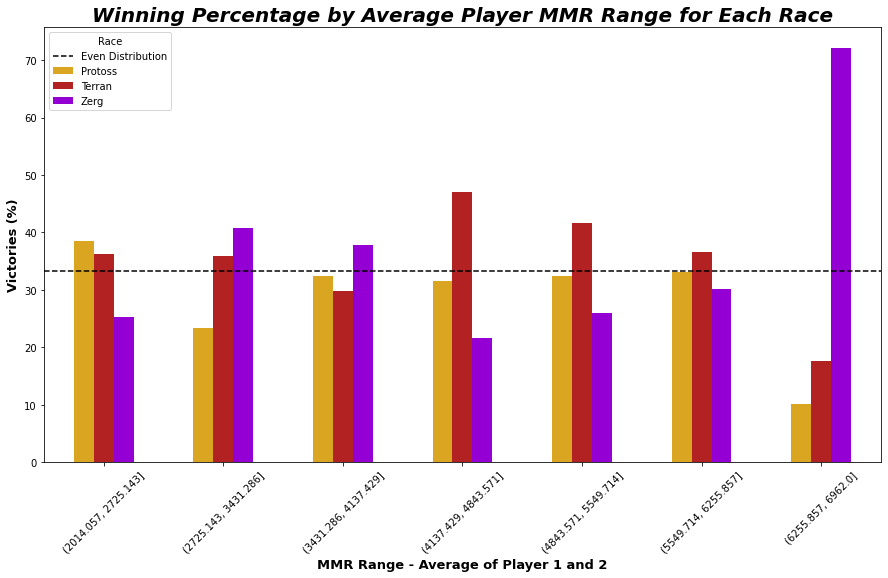

In [49]:
# create summary table of winning_race binned by average player mmr
bins = 7

# add average mmr column
replay_df['average_mmr'] = replay_df[
    ['player1_mmr', 'player2_mmr']
    ].mean(axis=1)

# divide mmr range into 10 bins
df_bins = pd.cut(replay_df['average_mmr'], bins=bins)

# group by df_bins
grouped_df = replay_df.groupby(df_bins)['winning_race'].value_counts().unstack()

# calculate each column as fraction of row total
grouped_df = grouped_df.div(grouped_df.sum(axis=1), axis=0).multiply(100)

# plot 
plt.figure()
grouped_df.plot(kind='bar', rot=45, color=COLOR_DICT)
# plot dotted line for 1/3
plt.axhline(y=100/3, color='k', linestyle='--', label='Even Distribution')
plt.ylabel('Victories (%)')
plt.xlabel('MMR Range - Average of Player 1 and 2')
plt.title(
    'Winning Percentage by Average Player MMR Range for Each Race',
    style='italic'
    )
plt.legend(title='Race', fancybox=True)
plt.show()

<Figure size 1080x576 with 0 Axes>

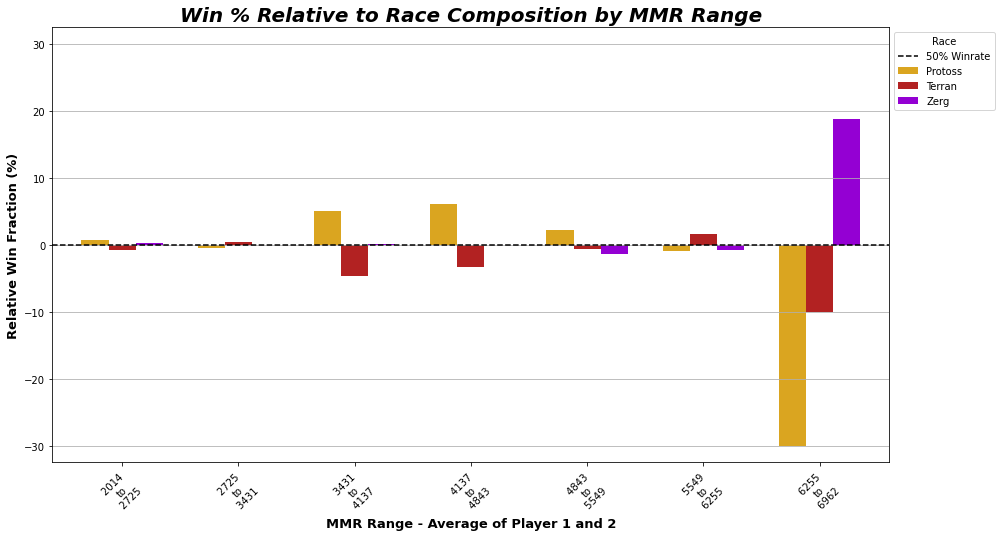

In [50]:
players_df = replay_df.groupby(df_bins)[
    'player1_race'].value_counts().unstack()

players_df += replay_df.groupby(df_bins)[
    'player2_race'].value_counts().unstack()

# group by df_bins
grouped_df = replay_df.groupby(df_bins)['winning_race'].value_counts().unstack()

for col in grouped_df:
    grouped_df[col] = (grouped_df[col] / players_df[col])*100 - 50

# plot 
plt.figure()
ax = grouped_df.plot(
    kind='bar',
    rot=45, 
    color=COLOR_DICT,
    width=0.7)

# plot dotted line for 1/3
plt.axhline(y=0, color='k', linestyle='--', label='50% Winrate')
plt.ylabel('Relative Win Fraction (%)')
plt.xlabel('MMR Range - Average of Player 1 and 2')
plt.title(
    'Win % Relative to Race Composition by MMR Range',
    style='italic'
    )
# set ylims to be symmetric around 0
max_y = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-max_y, ymax=max_y)
x_labels = [f'{int(x.left)} \nto\n {int(x.right)}' for x in grouped_df.index]
ax.set_xticklabels(x_labels, ha='center')
# place legend outside of plot
plt.legend(
    title='Race',
    fancybox=True,
    bbox_to_anchor=(1,1),
    loc='upper left')
# gridlines for y axis only
plt.grid(axis='y')
plt.show()


## Data Wrangling

Here we will:
* convert maphash to an index value.
* convert categorical columns to dummy variables.
* convert game_winner to a binary variable stating if player 1 won or not.
* keep only informative columns:
    * `winner`
    * `map`
    * `game_length`
    * `region`
    * `player1_race`
    * `player2_race`
    * `player1_mmr`
    * `player2_mmr`
* use player1 and 2 mmr to calculate player1 mmr advantage (i.e., player1 mmr - player2 mmr)

In [51]:
def wrangle_data(df):
    """
    wrangle_data
    Wrangle the df to create a dataframe with features and labels.
    Drop any unnecessary columns.

    Args:
        df (pd.DataFrame): DataFrame to be wrangled

    Returns:
        pd.DataFrame: Wrangled DataFrame
    """

    # list of columns we intend to keep
    keep_list = [
        'winner',
        'map',
        'game_length',
        'region',
        'player1_race',
        'player2_race',
        'player1_mmr',
        'player2_mmr'
        ]

    # drop all columns not in keep_list
    df = df[keep_list].copy()

    # convert maphash to an a more legible string
    maphash_converter = {}
    for i, maphash in enumerate(df['map'].unique()):
        maphash_converter[maphash] = 'map_' + str(i+1)

    df['map'] = df['map'].map(maphash_converter).copy()

    # convert winner to a binary value
    df['winner'] = df['winner'].map({1:1, 2:0}).copy()

    # convert region, player1_race and player2_race into dummies
    dummy_list = ['region', 'player1_race', 'player2_race', 'map']
    prefix_list = ['region', 'player1', 'player2', 'map']
    df = pd.get_dummies(
        df,
        prefix=prefix_list,
        columns=dummy_list,
        drop_first=True
        )

    # calculate the difference in mmr between the two players
    df['mmr_diff'] = df['player1_mmr'] - df['player2_mmr']

    # drop player1_mmr and player2_mmr
    df = df.drop(['player2_mmr'], axis=1)

    return df

In [52]:
clean_df = wrangle_data(replay_df)
display(clean_df.head())
clean_df.info()

,winner,game_length,player1_mmr,region_eu,region_kr,region_us,player1_Terran,player1_Zerg,player2_Terran,player2_Zerg,...,map_map_91,map_map_92,map_map_93,map_map_94,map_map_95,map_map_96,map_map_97,map_map_98,map_map_99,mmr_diff
0,1,371,4022.0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,520.0
1,1,502,3615.0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,48.0
2,1,902,3635.0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,82.0
3,1,350,6685.0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,728.0
4,0,514,2795.0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,-213.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6996 entries, 0 to 6995
Columns: 480 entries, winner to mmr_diff
dtypes: float64(2), int64(2), uint8(476)
memory usage: 3.4 MB


## Modeling

Attempt using a logistic model to predict victory based on cleaned metadata.


In [53]:
del replay_df

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# import svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

# import random forest
from sklearn.ensemble import RandomForestClassifier

# import KNN
from sklearn.neighbors import KNeighborsClassifier

# import grid_search
from sklearn.model_selection import GridSearchCV

# import warnings
import warnings

# suppress warnings
warnings.filterwarnings('ignore')

In [55]:
# do test train split
X_train, X_test, y_train, y_test = train_test_split(
    clean_df.drop('winner', axis=1),
    clean_df['winner'],
    test_size=0.2,
    random_state=42,
    stratify=clean_df['winner']
)


In [56]:
# use grid search to find best model
classifiers = [
    LogisticRegression(),
    SVC(),
    RandomForestClassifier(),
    KNeighborsClassifier()
]

best_models = {}

parameters = [{
        'LogisticRegression__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
        'LogisticRegression__penalty': ['l1', 'l2'],
        'LogisticRegression__solver': ['saga', 'newton-cg', 'lbfgs', 'sag']
    },
    {
        'SVC__C': [0.0001, 0.001, 0.01, 1, 10],
        'SVC__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'SVC__gamma': ['auto', 'scale']
    },
    {
        'RandomForestClassifier__n_estimators': [10, 30, 40, 60, 70, 100],
        'RandomForestClassifier__max_depth': [2, 5, 6, 8, 10],
        'RandomForestClassifier__min_samples_leaf': [2, 5, 10, 15, 20, 50]
    },
    {
        'KNeighborsClassifier__n_neighbors': [
            2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 200, 500, 1000]
    }
]

# loop through classifiers performing grid search
for i, classifier in enumerate(classifiers):
    if i != 0: # skip all but logistic regression
        continue
    # classifier name
    classifier_name = classifier.__class__.__name__
    # start timer
    timer = time.time()

    print(f'Testing {classifier_name}')
    print('____________________________________________')

    # create pipeline
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        (classifier_name, classifier)
    ])

    grid_search = GridSearchCV(
        pipe,
        param_grid=parameters[i],
        cv=5,
        scoring='accuracy',
        n_jobs=10
        )

    grid_search.fit(X_train, y_train)

    # store best model object
    best_models[classifier_name] = grid_search.best_estimator_

    print(f'Best parameters for {classifier_name}:')
    print(grid_search.best_params_)
    print(f'Best score for {classifier_name}:')
    print(f'{round(grid_search.best_score_*100,2)}%')
    print(f'Best estimator for {classifier_name}:')
    print(grid_search.best_estimator_)
    # convert seconds to HH::MM::SS
    print(f'Time taken: {time.strftime("%H:%M:%S", time.gmtime(time.time() - timer))}')
    print(
'_____________________________________________________________________________')

Testing LogisticRegression
____________________________________________
Best parameters for LogisticRegression:
{'LogisticRegression__C': 0.01, 'LogisticRegression__penalty': 'l1', 'LogisticRegression__solver': 'saga'}
Best score for LogisticRegression:
57.97%
Best estimator for LogisticRegression:
Pipeline(steps=[('scaler', StandardScaler()),
                ('LogisticRegression',
                 LogisticRegression(C=0.01, penalty='l1', solver='saga'))])
Time taken: 00:00:25
_____________________________________________________________________________


In [57]:
# get mean of winner column
print(f'Mean of winner column: {round(clean_df["winner"].mean(),2)*100}%')

Mean of winner column: 51.0%


In [58]:
# get coefs of best logistic regression model

lr_coef = pd.DataFrame(
    {'coef':best_models['LogisticRegression'].named_steps['LogisticRegression'].coef_[0]},
    index=clean_df.drop('winner', axis=1).columns
)

lr_coef['odds_ratio'] = lr_coef['coef'].apply(lambda x: math.exp(x))
lr_coef.sort_values(by='coef', ascending=False)

,coef,odds_ratio
mmr_diff,0.345797,1.413115
map_map_376,0.000000,1.000000
map_map_387,0.000000,1.000000
map_map_386,0.000000,1.000000
map_map_385,0.000000,1.000000
...,...,...
map_map_231,0.000000,1.000000
map_map_230,0.000000,1.000000
map_map_23,0.000000,1.000000
map_map_229,0.000000,1.000000


In [59]:
# pred test for best logistic regression model
lr_pred = best_models['LogisticRegression'].predict(X_test)

# get accuracy_score
print(f'Logistic Regression Accuracy Score: {round(accuracy_score(y_test, lr_pred)*100,2)}%')
# get confusion matrix
print(f'Logistic Regression Confusion Matrix:')
display(pd.DataFrame(
        confusion_matrix(y_test, lr_pred),
        columns=['loss_pred','win_pred'],
        index=['loss_actual','win_actual']
    ).style.background_gradient()
)

# print precision, recall, f1 score
print(f'Logistic Regression Precision: {round(precision_score(y_test, lr_pred)*100,2)}%')
print(f'Logistic Regression Recall: {round(recall_score(y_test, lr_pred)*100,2)}%')
print(f'Logistic Regression F1 Score: {round(f1_score(y_test, lr_pred)*100,2)}%')


Logistic Regression Accuracy Score: 56.79%
Logistic Regression Confusion Matrix:


,loss_pred,win_pred
loss_actual,276,405
win_actual,200,519


Logistic Regression Precision: 56.17%
Logistic Regression Recall: 72.18%
Logistic Regression F1 Score: 63.18%


In [63]:
blizz_df = pd.read_csv('data/blizzard_replays.csv')
blizz_df = wrangle_data(clean_replay_df(blizz_df))

# split into X and y
y = blizz_df['winner']
X = blizz_df.drop('winner', axis=1)
# add all missing columns from X_train to X with default value of 0
X = X.reindex(columns=X_train.columns, fill_value=0)

# use best logistic regression model to predict
lr_pred = best_models['LogisticRegression'].predict(X)

# get accuracy_score
print(f'Blizzard Replay Accuracy Score: {round(accuracy_score(y, lr_pred)*100,2)}%')
# get confusion matrix
print(f'Blizzard Replay Confusion Matrix:')
display(pd.DataFrame(
        confusion_matrix(y, lr_pred),
        columns=['loss_pred','win_pred'],
        index=['loss_actual','win_actual']
    ).style.background_gradient()
)

# print precision, recall, f1 score
print(f'Blizzard Replay Precision: {round(precision_score(y, lr_pred)*100,2)}%')
print(f'Blizzard Replay Recall: {round(recall_score(y, lr_pred)*100,2)}%')
print(f'Blizzard Replay F1 Score: {round(f1_score(y, lr_pred)*100,2)}%')


Drop duplicates dropped 0 rows
1v1 dropped 0 rows
Winner dropped 3338 rows
Game length dropped 17759 rows
Player race dropped 63923 rows
Player mmr dropped 34529 rows
Game speed dropped 0 rows
Ladder dropped 0 rows
Region dropped 0 rows
Drop NaN dropped 0 rows
Blizzard Replay Accuracy Score: 55.87%
Blizzard Replay Confusion Matrix:


,loss_pred,win_pred
loss_actual,220803,318716
win_actual,159538,384733


Blizzard Replay Precision: 54.69%
Blizzard Replay Recall: 70.69%
Blizzard Replay F1 Score: 61.67%
